In [ ]:
#basic Imports

import os
import glob
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pyarrow.parquet as pq

In [ ]:
#create graphs of yellow taxi dropoffs for each hour
#currently set up for 2018

import torch
import numpy as np
import pandas as pd
from torch_geometric.data import Data
import glob

#load data files
parquet_files = sorted(glob.glob('yellow_2018_data/yellow_tripdata_2018-*.parquet'))
df_list = [pd.read_parquet(f) for f in parquet_files]
yellow_df = pd.concat(df_list, ignore_index=True)

#filter times
yellow_df = yellow_df[
    (yellow_df['tpep_dropoff_datetime'] >= '2018-01-01') &
    (yellow_df['tpep_dropoff_datetime'] < '2019-01-01')
]

print(f"Filtered dataset: {len(yellow_df)} trips")

all_zones = sorted(
    set(yellow_df['PULocationID'].unique()) | set(yellow_df['DOLocationID'].unique())
)
zone_to_idx = {zone_id: idx for idx, zone_id in enumerate(all_zones)}
num_nodes = len(all_zones)

all_hours = pd.date_range('2018-01-01 00:00:00', '2018-12-31 23:00:00', freq='H')


holiday_dates = {
    pd.Timestamp('2018-01-01').date(),  # ny day 
    pd.Timestamp('2018-04-01').date(),  # easter
    pd.Timestamp('2018-07-04').date(),  # july4 
    pd.Timestamp('2018-11-22').date(),  # thanksgiving 
    pd.Timestamp('2018-12-24').date(),  # xmas eve
    pd.Timestamp('2018-12-25').date(),  # xmas day
    pd.Timestamp('2018-12-31').date(),  # ny eve
}

#actually build graphs
hourly_graphs = []
save_every = 500

for i, hour in enumerate(all_hours):
    hour_trips = yellow_df[
        yellow_df['tpep_dropoff_datetime'].dt.floor('H') == hour
    ]

    node_features = torch.zeros((num_nodes, 11), dtype=torch.float)

    if not hour_trips.empty:
        dropoff_counts = (
            hour_trips.groupby('DOLocationID').size().reset_index(name='dropoff_count')
        )
        agg_stats = (
            hour_trips.groupby('DOLocationID')
            .agg({'fare_amount': 'mean', 'congestion_surcharge': lambda x: x.dropna().mean()})
            .reset_index()
        )
        node_agg = agg_stats.merge(dropoff_counts, on='DOLocationID')

        for _, row in node_agg.iterrows():
            idx = zone_to_idx[row['DOLocationID']]
            node_features[idx, 0] = row['dropoff_count']
            node_features[idx, 1] = row['fare_amount'] if not np.isnan(row['fare_amount']) else 0.0
            node_features[idx, 2] = row['congestion_surcharge'] if not np.isnan(row['congestion_surcharge']) else 0.0

    hour_val = hour.hour
    dow_val = hour.dayofweek
    month_val = hour.month
    is_weekend = 1 if dow_val >= 5 else 0
    is_holiday = 1 if hour.date() in holiday_dates else 0

    node_features[:, 3] = np.sin(2 * np.pi * hour_val / 24)
    node_features[:, 4] = np.cos(2 * np.pi * hour_val / 24)
    node_features[:, 5] = np.sin(2 * np.pi * dow_val / 7)
    node_features[:, 6] = np.cos(2 * np.pi * dow_val / 7)
    node_features[:, 7] = np.sin(2 * np.pi * month_val / 12)
    node_features[:, 8] = np.cos(2 * np.pi * month_val / 12)
    node_features[:, 9] = is_weekend
    node_features[:, 10] = is_holiday


    hour_edges = (
        hour_trips.groupby(['PULocationID', 'DOLocationID'])
        .agg({'passenger_count': 'sum'})
        .reset_index()
    )
    trip_counts = (
        hour_trips.groupby(['PULocationID', 'DOLocationID'])
        .size()
        .reset_index(name='trip_count')
    )
    hour_edges = hour_edges.merge(trip_counts, on=['PULocationID', 'DOLocationID'])

    edge_list = []
    edge_attrs = []
    for _, row in hour_edges.iterrows():
        if row['PULocationID'] in zone_to_idx and row['DOLocationID'] in zone_to_idx:
            src = zone_to_idx[row['PULocationID']]
            dst = zone_to_idx[row['DOLocationID']]
            edge_list.append([src, dst])
            edge_attrs.append([row['trip_count'], row['passenger_count']])

    if len(edge_list) > 0:
        edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attrs, dtype=torch.float)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, 2), dtype=torch.float)

    graph = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
    hourly_graphs.append(graph)

    if (i + 1) % 100 == 0:
        print(f"Built {i + 1}/{len(all_hours)} graphs")
    if (i + 1) % save_every == 0:
        temp_save_path = f'aligned2018/hourly_graphs_checkpoint_{i + 1}.pt'
        torch.save(hourly_graphs, temp_save_path)
        print(f"Saved checkpoint: {temp_save_path}")

# Final save
final_save_path = 'aligned2018/hourly_graphs_final_2018.pt'
torch.save(hourly_graphs, final_save_path)
print(f"Done! Saved final graphs to {final_save_path}")

In [ ]:
#checks that graphs edges and parquets match 

import torch
import pandas as pd
import pickle


graphs = torch.load('aligned/hourly_graphs_final_2017.pt')
print(f"Loaded {len(graphs)} graphs.")

import glob

parquet_files = sorted(glob.glob('data/yellow_tripdata_2017-*.parquet'))
df_list = [pd.read_parquet(f) for f in parquet_files]
yellow_df = pd.concat(df_list, ignore_index=True)
print(f"Loaded {len(yellow_df)} total trips.")

all_zones = sorted(
    set(yellow_df['PULocationID'].unique()) | set(yellow_df['DOLocationID'].unique())
)
zone_to_idx = {zone_id: idx for idx, zone_id in enumerate(all_zones)}
idx_to_zone = {idx: zone_id for zone_id, idx in zone_to_idx.items()}
print(f"Mapped {len(all_zones)} unique zones.")

#select time to check 
target_idx = 335  
target_graph = graphs[target_idx]
print(f"Checking graph at index {target_idx}")

start_time = pd.Timestamp('2017-01-01 00:00:00')
target_hour = start_time + pd.Timedelta(hours=target_idx)
print(f"Corresponding hour: {target_hour}")


hour_trips = yellow_df[
    yellow_df['tpep_dropoff_datetime'].dt.floor('H') == target_hour
]

parquet_edges = (
    hour_trips.groupby(['PULocationID', 'DOLocationID'])
    .size()
    .reset_index(name='parquet_trip_count')
)

parquet_edge_dict = {
    (zone_to_idx[row['PULocationID']], zone_to_idx[row['DOLocationID']]): row['parquet_trip_count']
    for _, row in parquet_edges.iterrows()
}

mismatch_count = 0
for edge_idx, (src, dst) in enumerate(target_graph.edge_index.T):
    src_idx = src.item()
    dst_idx = dst.item()
    graph_trip_count = target_graph.edge_attr[edge_idx, 0].item()
    parquet_trip_count = parquet_edge_dict.get((src_idx, dst_idx), 0)

    if graph_trip_count != parquet_trip_count:
        mismatch_count += 1
        print(f"Edge {idx_to_zone[src_idx]} → {idx_to_zone[dst_idx]}: graph={graph_trip_count}, parquet={parquet_trip_count}")

if mismatch_count == 0:
    print("All graph edge trip counts match parquet!")
else:
    print(f"Found {mismatch_count} mismatches in edge counts.")



In [ ]:
#checks that graphs nodes and parquets match 
graphs = torch.load('aligned/hourly_graphs_final_2017.pt')
print(f"Loaded {len(graphs)} graphs.")

target_idx = 212  # or any other index you want
target_graph = graphs[target_idx]

print(f"Checking graph at index {target_idx}")

start_time = pd.Timestamp('2017-01-01 00:00:00')
target_hour = start_time + pd.Timedelta(hours=target_idx)
print(f"Corresponding hour: {target_hour}")

hour_trips = yellow_df[
    yellow_df['tpep_dropoff_datetime'].dt.floor('H') == target_hour
]

parquet_node_counts = (
    hour_trips.groupby('DOLocationID')
    .size()
    .reset_index(name='parquet_dropoff_count')
)

parquet_node_dict = {
    zone_to_idx[row['DOLocationID']]: row['parquet_dropoff_count']
    for _, row in parquet_node_counts.iterrows()
}

mismatch_count = 0
for node_idx in range(target_graph.num_nodes):
    graph_count = target_graph.x[node_idx, 0].item()
    parquet_count = parquet_node_dict.get(node_idx, 0)

    if graph_count != parquet_count:
        mismatch_count += 1
        print(f"Node {idx_to_zone[node_idx]} (idx {node_idx}): graph={graph_count}, parquet={parquet_count}")

if mismatch_count == 0:
    print("All node dropoff counts match parquet!")
else:
    print(f"Found {mismatch_count} mismatches in node counts.")


In [ ]:
#some other checks to make sure everything is set up correctly
import pandas as pd

# Load the saved graphs
import torch
hourly_graphs_final = torch.load('aligned/hourly_graphs_final_2017.pt')


start_time = pd.Timestamp('2017-01-01 00:00:00')
num_graphs = len(hourly_graphs_final)
hourly_timestamps = pd.date_range(start=start_time, periods=num_graphs, freq='H')



for node_idx in range(target_graph.num_nodes):
    graph_node_count = target_graph.x[node_idx, 0].item()
    summed_edge_count = sum(
        target_graph.edge_attr[edge_idx, 0].item()
        for edge_idx, (src, dst) in enumerate(target_graph.edge_index.T)
        if dst.item() == node_idx
    )

    if graph_node_count != summed_edge_count:
        print(f"Node {idx_to_zone[node_idx]} mismatch: graph node count={graph_node_count}, summed edge count={summed_edge_count}")

target_hour = pd.Timestamp('2017-01-01 0:00:00')
target_idx = hourly_timestamps.get_loc(target_hour)
target_graph = hourly_graphs_final[target_idx]

print(f"Graph x[:, 0] counts at {target_hour}:")
print(target_graph.x[:, 0])

num_nodes = target_graph.x.shape[0]
recomputed_dropoff_counts = torch.zeros(num_nodes)
for edge_idx, (src, dst) in enumerate(target_graph.edge_index.T):
    recomputed_dropoff_counts[dst] += target_graph.edge_attr[edge_idx, 0]

print("Recomputed dropoff counts from edges:")
print(recomputed_dropoff_counts)


In [ ]:
#load test + validation data and inspect 

import torch

hourly_graphs_final = torch.load('aligned/hourly_graphs_final_2017.pt')

print(f"Total graphs loaded: {len(hourly_graphs_final)}")

sample_graph = hourly_graphs_final[0]
print(sample_graph)

print(f"\nNode feature shape (x): {sample_graph.x.shape}")
print(f"Edge index shape: {sample_graph.edge_index.shape}")
print(f"Edge attribute shape (edge_attr): {sample_graph.edge_attr.shape}")

In [ ]:
#check mapping. literally just read zone = index in graph + 1 (since zero vs 1 indexing)
all_zones = sorted(set(yellow_df['PULocationID'].unique()) | set(yellow_df['DOLocationID'].unique()))
zone_to_idx = {zone_id: idx for idx, zone_id in enumerate(all_zones)}
idx_to_zone = {idx: zone_id for zone_id, idx in zone_to_idx.items()}

print(f"Mapped {len(all_zones)} zones")
print(zone_to_idx)
print(idx_to_zone)


In [ ]:
#Dataset Structure 
from torch.utils.data import Dataset

class TaxiGraphSequenceDataset(Dataset):
    def __init__(self, graphs, seq_len=24):
        self.graphs = graphs
        self.seq_len = seq_len

    def __len__(self):
        return len(self.graphs) - self.seq_len

    def __getitem__(self, idx):
        input_seq = self.graphs[idx: idx + self.seq_len]
        target_graph = self.graphs[idx + self.seq_len]

        #x = target_graph.x  
        # [num_nodes, 11]

       
        calendar_vector = target_graph.x[0, 3:12] 
        dropoff_counts = target_graph.x[:, 0]

        return input_seq, calendar_vector, dropoff_counts


In [ ]:
#stacking for batching 
def graph_sequence_collate(batch):
    input_seqs = [item[0] for item in batch]  # keep as list of lists
    next_calendars = torch.stack([item[1] for item in batch], dim=0)
    target_dropoffs = torch.stack([item[2] for item in batch], dim=0)
    return input_seqs, next_calendars, target_dropoffs


In [ ]:
#loading data again lol
hourly_graphs_final = torch.load('aligned/hourly_graphs_final_2017.pt')
full_dataset = TaxiGraphSequenceDataset(hourly_graphs_final, seq_len=24)


In [ ]:
#create train and validation sets. 
#train on first 80% of the year and validate on the rest 

num_samples = len(full_dataset)
num_train = int(0.8 * num_samples)
num_val = num_samples - num_train

# Split by slicing, not random_split
train_dataset = torch.utils.data.Subset(full_dataset, range(0, num_train))
val_dataset = torch.utils.data.Subset(full_dataset, range(num_train, num_samples))

print(f"Train range: 0 to {num_train - 1}")
print(f"Val range: {num_train} to {num_samples - 1}")


In [ ]:
#another check
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=graph_sequence_collate)
val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=graph_sequence_collate)

print("TRAIN DATASET CLASS:", type(train_loader.dataset))
print("VAL DATASET CLASS:", type(val_loader.dataset))



In [ ]:
#the model parts

import torch.nn as nn
import torch_geometric.nn as pyg_nn

class GraphEncoder(nn.Module):
    def __init__(self, node_in_dim, hidden_dim, out_dim, num_layers=2):
        super(GraphEncoder, self).__init__()
        self.conv = pyg_nn.GraphSAGE(node_in_dim, hidden_dim, num_layers)
        self.pool = pyg_nn.global_mean_pool

    def forward(self, x, edge_index, batch):
        x = self.conv(x, edge_index)
        x = torch.relu(x)
        graph_emb = self.pool(x, batch)
        return graph_emb

class TemporalPredictor(nn.Module):
    def __init__(self, graph_emb_dim, rnn_hidden_dim, num_layers=2):
        super(TemporalPredictor, self).__init__()
        self.rnn = nn.GRU(graph_emb_dim, rnn_hidden_dim, batch_first=True, num_layers=num_layers)

    def forward(self, emb_seq):
        rnn_out, _ = self.rnn(emb_seq)
        return rnn_out[:, -1, :] 


In [ ]:
#the model 
class GNNRNNModel(nn.Module):
    def __init__(self, node_in_dim, gnn_hidden_dim, gnn_out_dim, rnn_hidden_dim, calendar_dim, num_nodes):
        super(GNNRNNModel, self).__init__()
        self.graph_encoder = GraphEncoder(node_in_dim, gnn_hidden_dim, gnn_out_dim)
        self.temporal_predictor = TemporalPredictor(gnn_out_dim, rnn_hidden_dim)
        self.fc_final = nn.Linear(rnn_hidden_dim + calendar_dim, num_nodes)

    def forward(self, graph_seq, next_calendar):
        emb_list = []
        for graph in graph_seq:
            x, edge_index, batch = graph.x, graph.edge_index, graph.batch
            graph_emb = self.graph_encoder(x, edge_index, batch)
            emb_list.append(graph_emb)
        emb_seq = torch.stack(emb_list, dim=1)  # [batch_size, seq_len, graph_emb_dim]
        temporal_out = self.temporal_predictor(emb_seq)
        combined = torch.cat([temporal_out, next_calendar], dim=1)
        pred = self.fc_final(combined)
        return pred




In [ ]:
#use GPU 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
#create model and loss and optimizer, etc. 
import torch.optim as optim

model = GNNRNNModel(node_in_dim=11, gnn_hidden_dim=128, gnn_out_dim=128,
                    rnn_hidden_dim=128, calendar_dim=8, num_nodes=265)
model = model.to(device)


loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
#train and validate functioms 
import time
import torch

def train_one_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    epoch_loss = 0.0
    total_mae = 0.0
    total_rmse = 0.0
    total_ss_res = 0.0
    total_ss_tot = 0.0
    total_targets = 0.0
    num_samples = 0

    count = 0

    for input_seqs, next_calendars, target_dropoffs in train_loader:
        input_seqs = [g.to(device) for g in input_seqs]

        #print("hi")
        if (count % 100) == 0:
            print("hi")
        next_calendars = next_calendars.to(device)
        target_dropoffs = target_dropoffs.to(device)

        optimizer.zero_grad()

        preds = model(input_seqs, next_calendars)
        loss = loss_fn(preds, target_dropoffs)
        loss.backward()
        optimizer.step()

        metrics
        epoch_loss += loss.item()

        mae = F.l1_loss(preds, target_dropoffs, reduction='sum').item()
        mse = F.mse_loss(preds, target_dropoffs, reduction='sum').item()
        total_mae += mae
        total_rmse += mse 

        ss_res = torch.sum((preds - target_dropoffs) ** 2).item()
        ss_tot = torch.sum((target_dropoffs - target_dropoffs.mean()) ** 2).item()
        total_ss_res += ss_res
        total_ss_tot += ss_tot

        total_targets += target_dropoffs.sum().item()
        num_samples += target_dropoffs.numel()

        if (count % 100) == 0:
            print(f"Batch {count}: Running Loss {loss.item():.4f}")
        count += 1

    avg_loss = epoch_loss / len(train_loader)
    avg_mae = total_mae / num_samples
    avg_rmse = (total_rmse / num_samples) ** 0.5
    avg_target = total_targets / num_samples
    r2 = 1 - (total_ss_res / total_ss_tot) if total_ss_tot != 0 else float('nan')
    return  avg_loss, avg_mae, avg_rmse, r2,  avg_target


def validate(model, val_loader, loss_fn, device):
    model.eval()
    epoch_loss = 0.0
    total_mae = 0.0
    total_rmse = 0.0
    total_ss_res = 0.0
    total_ss_tot = 0.0
    total_targets = 0.0
    num_samples = 0

    with torch.no_grad():
        for input_seqs, next_calendars, target_dropoffs in val_loader:
            input_seqs = [g.to(device) for g in input_seqs]
            next_calendars = next_calendars.to(device)
            target_dropoffs = target_dropoffs.to(device)

            preds = model(input_seqs, next_calendars)
            loss = loss_fn(preds, target_dropoffs)
            epoch_loss += loss.item()

            mae = F.l1_loss(preds, target_dropoffs, reduction='sum').item()
            total_mae += mae

            mse = F.mse_loss(preds, target_dropoffs, reduction='sum').item()
            total_rmse += mse

            ss_res = torch.sum((preds - target_dropoffs) ** 2).item()
            ss_tot = torch.sum((target_dropoffs - target_dropoffs.mean()) ** 2).item()
            total_ss_res += ss_res
            total_ss_tot += ss_tot
            total_targets += target_dropoffs.sum().item()
            num_samples += target_dropoffs.numel()

            
    avg_mae = total_mae / num_samples
    avg_rmse = (total_rmse / num_samples) ** 0.5
    avg_target = total_targets / num_samples
    r2 = 1 - (total_ss_res / total_ss_tot) if total_ss_tot != 0 else float('nan')
    avg_loss = epoch_loss / len(val_loader)
    return avg_loss, avg_mae, avg_rmse, r2,  avg_target


In [ ]:
#epochs with train and validation data and save metrics to a CSV 
import torch.nn.functional as F

num_epochs = 40
best_val_loss = float('inf')
loss_history = []
val_losses = []
train_losses = []

for epoch in range(1, num_epochs + 1):
    start_time = time.time()

    train_loss, train_mae, train_rmse, train_r2, train_avg_tar = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_mae, val_rmse, val_r2, val_avg_tar = validate(model, val_loader, loss_fn, device)

    
    

    elapsed = time.time() - start_time
    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Time = {elapsed:.1f}s")

    loss_history.append({
        'epoch': epoch,
        'train_loss': train_loss,
        'train_mae': train_mae,
        'train_rmse': train_rmse,
        'train_avg_target': train_avg_tar,
        'train_r2': train_r2,
        'val_loss': val_loss,
        'val_mae': val_mae,
        'val_rmse': val_rmse,
        'val_avg_target': val_avg_tar,
        'val_r2': val_r2,
        'time_sec': elapsed
    })

    loss_history.append({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss})

    # save best 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'newtry/TEST5best_model.pt')
        print("Saved new best model!")

import pandas as pd
pd.DataFrame(loss_history).to_csv('newtry/TEST5loss_history.csv', index=False)


In [ ]:
#now train on whole dataset to have data from the whole year before testing 

from torch_geometric.loader import DataLoader


full_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
print(f"Full dataset combined: {len(full_dataset)} samples")

full_loader = DataLoader(full_dataset, batch_size=8, shuffle=True, collate_fn=graph_sequence_collate)

fine_tune_epochs = 10  # or however many you want

for epoch in range(1, fine_tune_epochs + 1):
    start_time = time.time()
    train_loss, train_mae, train_rmse, train_r2, train_avg_tar = train_one_epoch(
        model, full_loader, optimizer, loss_fn, device
    )
    elapsed = time.time() - start_time
    print(f"Fine-tune Epoch {epoch}: Loss = {train_loss:.4f}, Time = {elapsed:.1f}s")

    loss_history.append({
        'epoch': epoch,
        'train_loss': train_loss,
        'train_mae': train_mae,
        'train_rmse': train_rmse,
        'train_avg_target': train_avg_tar,
        'train_r2': train_r2,
        'time_sec': elapsed
    })

    if train_loss < best_ft_loss:
        best_ft_loss = train_loss
        torch.save(model.state_dict(), 'newtry/FINAL2_finetuned_model.pt')
        print("Saved best fine-tuned model!")

pd.DataFrame(loss_history).to_csv('newtry/FINAL2_finetune_loss_history.csv', index=False)
print("Fine-tuning complete. History saved.")


In [ ]:

full_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
print(f"Full dataset combined: {len(full_dataset)} samples")
full_loader = DataLoader(full_dataset, batch_size=8, shuffle=True, collate_fn=graph_sequence_collate)

In [ ]:
#load 2018 data -> the test dataset 
test_graphs_2018 = torch.load('hourly_graphs_final_2018_patched.pt')
test_dataset = TaxiGraphSequenceDataset(test_graphs_2018, seq_len=24)
test_loader = DataLoader(test_dataset, batch_size=8, collate_fn=graph_sequence_collate)


In [ ]:
#load final model 
model.load_state_dict(torch.load('newtry/FINAL2_finetuned_model.pt'))
model.to(device)
model.eval()


In [ ]:
import torch.nn.functional as F

#check metrics on test set 
train_loss, train_mae, train_rmse, train_r2, train_avg_tar = validate(
    model, full_loader, loss_fn, device
)
print(f"Train Loss: {train_loss:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Average Target Value: {test_avg_tar:.4f}")


In [ ]:
import torch.nn.functional as F

# Check metrics on full training set
train_loss, train_mae, train_rmse, train_r2, train_avg_tar = validate(
    model, full_loader, loss_fn, device
)

# Compute relative metrics
relative_mae = 100 * train_mae / train_avg_tar if train_avg_tar != 0 else float('nan')
relative_rmse = 100 * train_rmse / train_avg_tar if train_avg_tar != 0 else float('nan')

# Print results
print(f"Train Loss: {train_loss:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Average Target Value: {train_avg_tar:.4f}")
print(f"Relative MAE: {relative_mae:.2f}%")
print(f"Relative RMSE: {relative_rmse:.2f}%")


In [ ]:
#now check accuracy on test 
test_loss, test_mae, test_rmse, test_r2, test_avg_tar = validate(
    model, test_loader, loss_fn, device
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Average Target Value: {test_avg_tar:.4f}")

In [ ]:
test_loss, test_mae, test_rmse, test_r2, test_avg_tar = validate(
    model, test_loader, loss_fn, device
)

relative_mae = 100 * test_mae / test_avg_tar if test_avg_tar != 0 else float('nan')
relative_rmse = 100 * test_rmse / test_avg_tar if test_avg_tar != 0 else float('nan')


print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Average Target Value: {test_avg_tar:.4f}")
print(f"Relative MAE: {relative_mae:.2f}%")
print(f"Relative RMSE: {relative_rmse:.2f}%")

In [ ]:
#get all test predictions -> but note what is saved is like not labeled or anything just to look at 
all_preds_test = []
all_targets_test = []

model.eval()
with torch.no_grad():
    for input_seqs, next_calendars, target_dropoffs in test_loader:
        input_seqs = [g.to(device) for g in input_seqs]
        next_calendars = next_calendars.to(device)
        preds = model(input_seqs, next_calendars)

        all_preds.append(preds.cpu())
        all_targets.append(target_dropoffs.cpu())

all_preds_test = torch.cat(all_preds)
all_targets_test = torch.cat(all_targets)

import pandas as pd
df = pd.DataFrame({
    'predicted': all_preds_test.flatten().numpy(),
    'actual': all_targets_test.flatten().numpy()
})
df.to_csv('test/test2_predictions.csv', index=False)
print("Saved test predictions to CSV!")


In [ ]:
all_preds_full = []
all_targets_full = []

with torch.no_grad():
    for input_seqs, next_calendars, target_dropoffs in full_loader:
        input_seqs = [g.to(device) for g in input_seqs]
        next_calendars = next_calendars.to(device)
        target_dropoffs = target_dropoffs.to(device)

        preds = model(input_seqs, next_calendars)
        all_preds_full.append(preds.cpu())
        all_targets_full.append(target_dropoffs.cpu())

all_preds_full = torch.cat(all_preds_full, dim=0)  
all_targets_full = torch.cat(all_targets_full, dim=0)  


In [ ]:
#save test preds, 2018
import pandas as pd

num_timesteps = all_preds_test.shape[0]
num_zones = all_preds_test.shape[1]

zone_ids = [z + 1 for z in range(num_zones)] * num_timesteps

timestep_ids = []
for t in range(num_timesteps):
    timestep_ids.extend([t] * num_zones)

flat_preds = all_preds_test.flatten().numpy()
flat_actuals = all_targets_test.flatten().numpy()

df = pd.DataFrame({
    'timestep': timestep_ids,
    'zone_id': zone_ids,
    'predicted': flat_preds,
    'actual': flat_actuals
})

df.to_csv('test/test4_predictions.csv', index=False)
print("Saved test predictions with timesteps and zone IDs to CSV!")


In [ ]:
#save 2017 preds
import pandas as pd

num_timesteps = all_preds_full.shape[0]
num_zones = all_preds_full.shape[1]

zone_ids = [z + 1 for z in range(num_zones)] * num_timesteps

timestep_ids = []
for t in range(num_timesteps):
    timestep_ids.extend([t] * num_zones)

flat_preds = all_preds_test.flatten().numpy()
flat_actuals = all_targets_test.flatten().numpy()

df = pd.DataFrame({
    'timestep': timestep_ids,
    'zone_id': zone_ids,
    'predicted': flat_preds,
    'actual': flat_actuals
})

df.to_csv('test/full_predictions.csv', index=False)
print("Saved test predictions with timesteps and zone IDs to CSV!")

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

preds_np = all_preds_full.numpy()
targets_np = all_targets_full.numpy()

num_zones = preds_np.shape[1]

zone_metrics = []

for zone_idx in range(num_zones):
    y_true = targets_np[:, zone_idx]
    y_pred = preds_np[:, zone_idx]
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    zone_metrics.append({
        'zone_id': zone_idx + 1, 
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

import pandas as pd
zone_df = pd.DataFrame(zone_metrics)
zone_df.to_csv('test/per_zone_metrics_full.csv', index=False)
print("Saved per-zone metrics to CSV!")


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


preds_np = all_preds_test.numpy()
targets_np = all_targets_test.numpy()

num_zones = preds_np.shape[1]

zone_metrics = []

for zone_idx in range(num_zones):
    y_true = targets_np[:, zone_idx]
    y_pred = preds_np[:, zone_idx]
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    zone_metrics.append({
        'zone_id': zone_idx + 1,  
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })


import pandas as pd
zone_df = pd.DataFrame(zone_metrics)
zone_df.to_csv('test/per_zone_metrics_test.csv', index=False)
print("Saved per-zone metrics to CSV!")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


preds_np = all_preds_full.numpy()
targets_np = all_targets_full.numpy()

num_zones = preds_np.shape[1]

zone_metrics = []

for zone_idx in range(num_zones):
    y_true = targets_np[:, zone_idx]
    y_pred = preds_np[:, zone_idx]
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mean_actual = np.mean(y_true)
    
    zone_metrics.append({
        'zone_id': zone_idx + 1, 
        'mean_actual': mean_actual,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })


zone_df = pd.DataFrame(zone_metrics)
zone_df.to_csv('test/per_zone_metrics_with_mean.csv', index=False)
print("Saved per-zone metrics with average actual to CSV!")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


preds_np = all_preds_test.numpy()
targets_np = all_targets_test.numpy()

num_zones = preds_np.shape[1]

zone_metrics = []

for zone_idx in range(num_zones):
    y_true = targets_np[:, zone_idx]
    y_pred = preds_np[:, zone_idx]
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mean_actual = np.mean(y_true)
    
    zone_metrics.append({
        'zone_id': zone_idx + 1,  
        'mean_actual': mean_actual,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

# Save as DataFrame
zone_df = pd.DataFrame(zone_metrics)
zone_df.to_csv('test/test_per_zone_metrics_with_mean.csv', index=False)
print("Saved per-zone metrics with average actual to CSV!")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

preds_np = all_preds_full.numpy()
targets_np = all_targets_full.numpy()

num_zones = preds_np.shape[1]

zone_metrics = []

for zone_idx in range(num_zones):
    y_true = targets_np[:, zone_idx]
    y_pred = preds_np[:, zone_idx]
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mean_actual = np.mean(y_true)
    
    rel_mae = 100 * mae / mean_actual if mean_actual != 0 else np.nan
    rel_rmse = 100 * rmse / mean_actual if mean_actual != 0 else np.nan
    
    zone_metrics.append({
        'zone_id': zone_idx + 1,  # assuming 1-indexed zone IDs
        'mean_actual': mean_actual,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Relative_MAE_%': rel_mae,
        'Relative_RMSE_%': rel_rmse
    })

zone_df = pd.DataFrame(zone_metrics)
zone_df.to_csv('test/per_zone_metrics_with_mean.csv', index=False)
print("Saved per-zone metrics with relative errors to CSV!")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


targets_np = all_targets_test.numpy()

num_zones = preds_np.shape[1]

zone_metrics = []

for zone_idx in range(num_zones):
    y_true = targets_np[:, zone_idx]
    y_pred = preds_np[:, zone_idx]
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mean_actual = np.mean(y_true)
    
    rel_mae = 100 * mae / mean_actual if mean_actual != 0 else np.nan
    rel_rmse = 100 * rmse / mean_actual if mean_actual != 0 else np.nan
    
    zone_metrics.append({
        'zone_id': zone_idx + 1, 
        'mean_actual': mean_actual,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Relative_MAE_%': rel_mae,
        'Relative_RMSE_%': rel_rmse
    })

zone_df = pd.DataFrame(zone_metrics)
zone_df.to_csv('test/per_zone_metrics_with_mean_test.csv', index=False)
print("Saved per-zone metrics with relative errors to CSV!")


In [ ]:
#for 2017 
import matplotlib.pyplot as plt
import pandas as pd
os.makedirs('Figures/train', exist_ok=True)


zone_df = pd.read_csv('test/per_zone_metrics_full.csv')


top_mae = zone_df.sort_values('MAE', ascending=False).head(10)
plt.figure()
plt.bar(top_mae['zone_id'].astype(str), top_mae['MAE'])
plt.xlabel('Zone ID')
plt.ylabel('Raw MAE')
plt.title('Zones with Highest Raw MAE in 2017')
plt.savefig('Figures/train/top10_mae_zones.png', dpi=300, bbox_inches='tight')
plt.show()



plt.figure()
plt.scatter(zone_df['MAE'], zone_df['RMSE'])
plt.xlabel('Raw MAE')
plt.ylabel('Raw RMSE')
plt.title('MAE vs RMSE per Zone in 2017')
plt.savefig('Figures/train/MAEvRMSEraw.png', dpi=300, bbox_inches='tight')
plt.show()



if 'R2' in zone_df.columns:
    plt.figure()
    plt.hist(zone_df['R2'], bins=20)
    plt.xlabel('R²')
    plt.ylabel('Number of Zones')
    plt.title('Distribution of R² Across Zones in 2017')
    plt.savefig('Figures/train/R2byZone.png', dpi=300, bbox_inches='tight')
    plt.show()



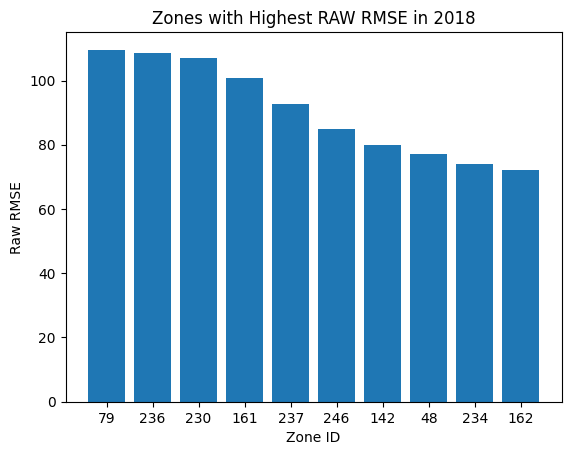

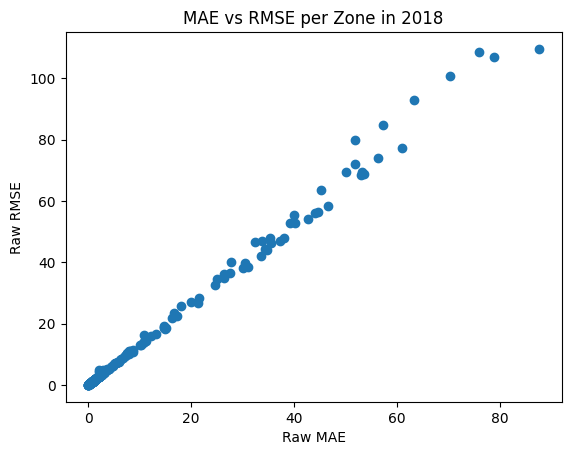

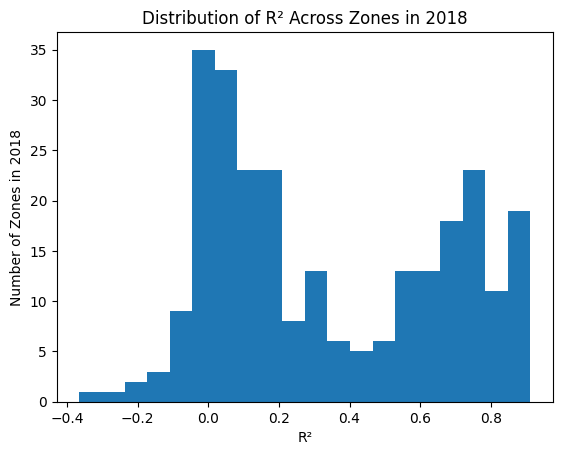

In [143]:
#for test set
import matplotlib.pyplot as plt
import pandas as pd


zone_df = pd.read_csv('test/per_zone_metrics_test.csv')

top_mae = zone_df.sort_values('RMSE', ascending=False).head(10)
plt.figure()
plt.bar(top_mae['zone_id'].astype(str), (top_mae['RMSE']))
plt.xlabel('Zone ID')
plt.ylabel('Raw RMSE')
plt.title('Zones with Highest RAW RMSE in 2018')
plt.savefig('Figures/train/top10_mae_zones.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure()
plt.scatter(zone_df['MAE'], zone_df['RMSE'])
plt.xlabel('Raw MAE')
plt.ylabel('Raw RMSE')
plt.title('MAE vs RMSE per Zone in 2018')
plt.savefig('Figures/train/MAEvRMSEraw.png', dpi=300, bbox_inches='tight')
plt.show()


if 'R2' in zone_df.columns:
    plt.figure()
    plt.hist(zone_df['R2'], bins=20)
    plt.xlabel('R²')
    plt.ylabel('Number of Zones in 2018')
    plt.title('Distribution of R² Across Zones in 2018')
    plt.savefig('Figures/test/R2byZone.png', dpi=300, bbox_inches='tight')
    plt.show()

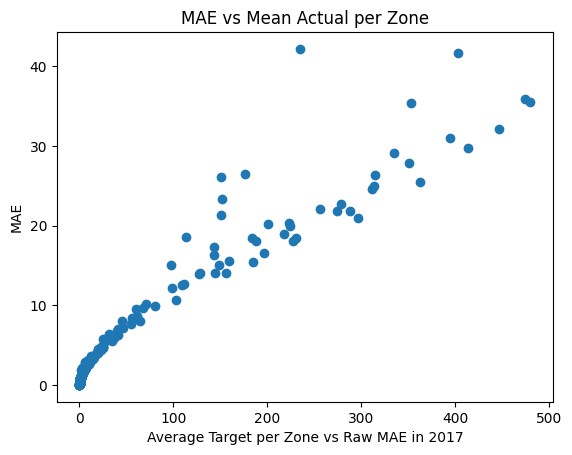

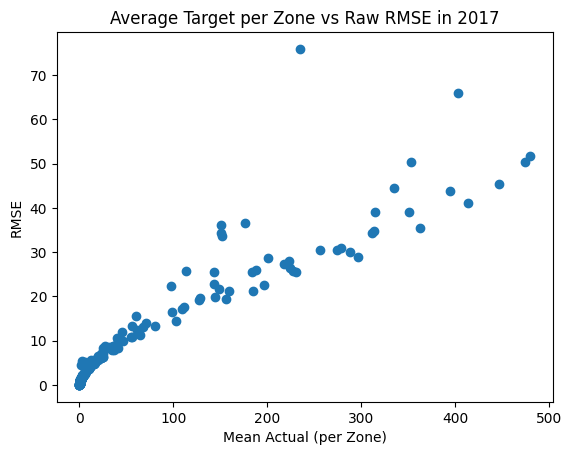

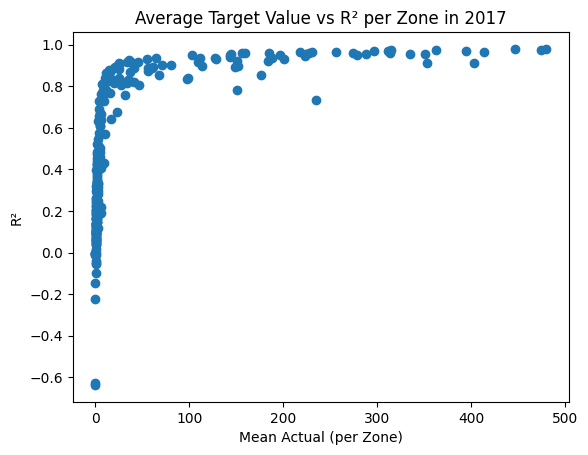

In [144]:
#for 2017 
import pandas as pd
import matplotlib.pyplot as plt

zone_df = pd.read_csv('test/per_zone_metrics_with_mean.csv')

plt.figure()
plt.scatter(zone_df['mean_actual'], zone_df['MAE'])
plt.xlabel('Average Target per Zone vs Raw MAE in 2017')
plt.ylabel('MAE')
plt.title('MAE vs Mean Actual per Zone')
plt.savefig('Figures/train/targetvsrawMAE.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure()
plt.scatter(zone_df['mean_actual'], zone_df['RMSE'])
plt.xlabel('Mean Actual (per Zone)')
plt.ylabel('RMSE')
plt.title('Average Target per Zone vs Raw RMSE in 2017')
plt.savefig('Figures/train/targetvsrawRMSE.png', dpi=300, bbox_inches='tight')
plt.show()

if 'R2' in zone_df.columns:
    plt.figure()
    plt.scatter(zone_df['mean_actual'], zone_df['R2'])
    plt.xlabel('Mean Actual (per Zone)')
    plt.ylabel('R²')
    plt.title('Average Target Value vs R² per Zone in 2017')
    plt.savefig('Figures/train/R2vstargetZone.png', dpi=300, bbox_inches='tight')
    plt.show()


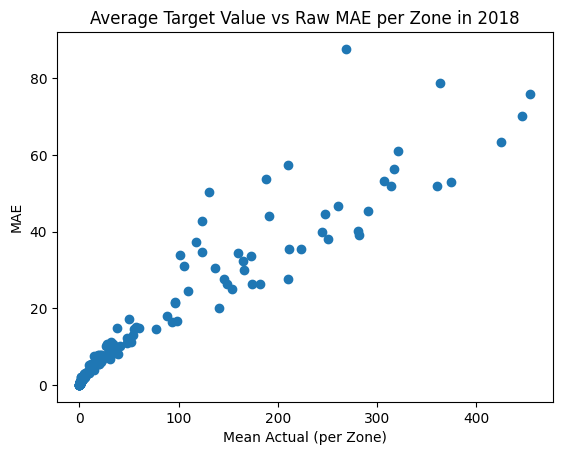

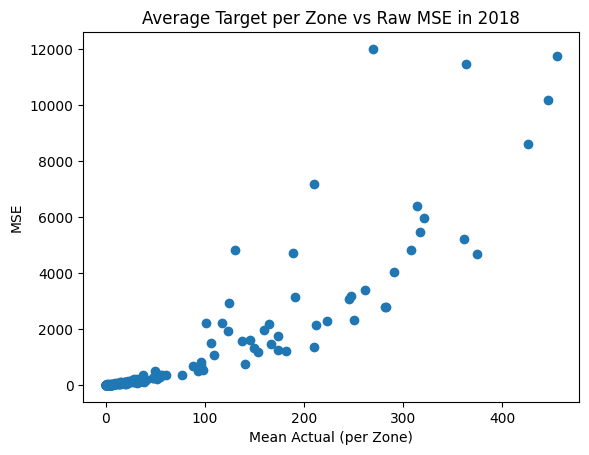

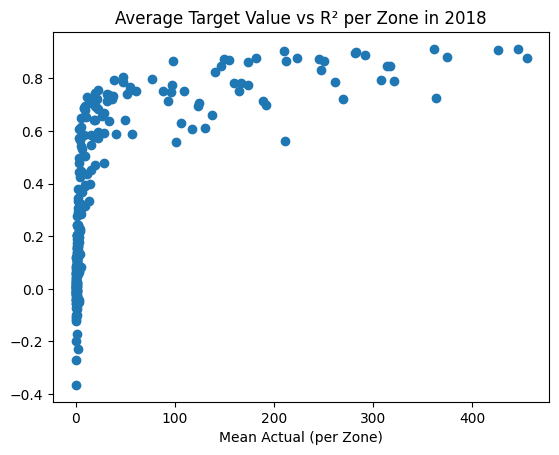

In [136]:
import pandas as pd
import matplotlib.pyplot as plt

zone_df = pd.read_csv('test/per_zone_metrics_with_mean_test.csv')

plt.figure()
plt.scatter(zone_df['mean_actual'], zone_df['MAE'])
plt.xlabel('Mean Actual (per Zone)')
plt.ylabel('MAE')
plt.title('Average Target Value vs Raw MAE per Zone in 2018')
plt.savefig('Figures/test/targetvsrawMAE.png', dpi=300, bbox_inches='tight')

plt.show()

plt.figure()
plt.scatter(zone_df['mean_actual'], zone_df['RMSE'] **2 )
plt.xlabel('Mean Actual (per Zone)')
plt.ylabel('MSE')
plt.title('Average Target per Zone vs Raw MSE in 2018')
plt.savefig('Figures/test/targetvsrawRMSE.png', dpi=300, bbox_inches='tight')
plt.show()

if 'R2' in zone_df.columns:
    plt.figure()
    plt.scatter(zone_df['mean_actual'], zone_df['R2'])
    plt.xlabel('Mean Actual (per Zone)')
    plt.title('Average Target Value vs R² per Zone in 2018')
    plt.savefig('Figures/test/R2vstargetZone.png', dpi=300, bbox_inches='tight')
    plt.show()


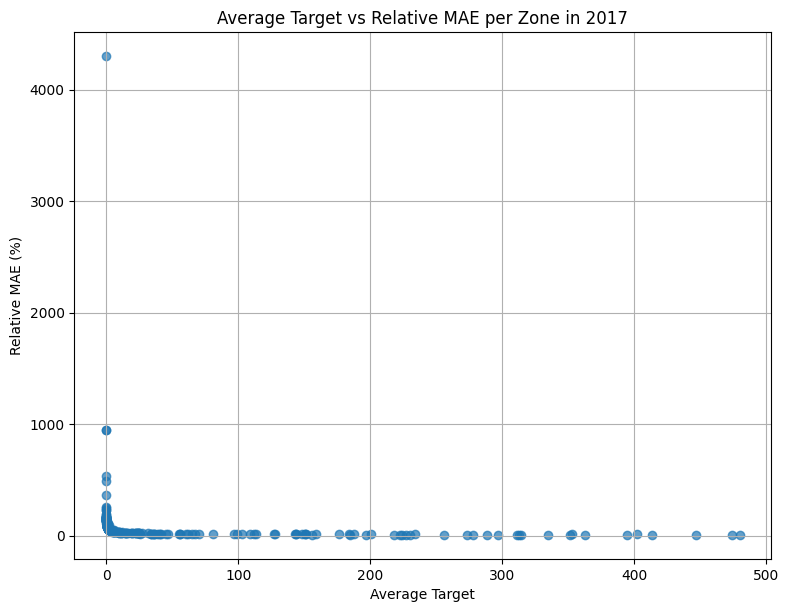

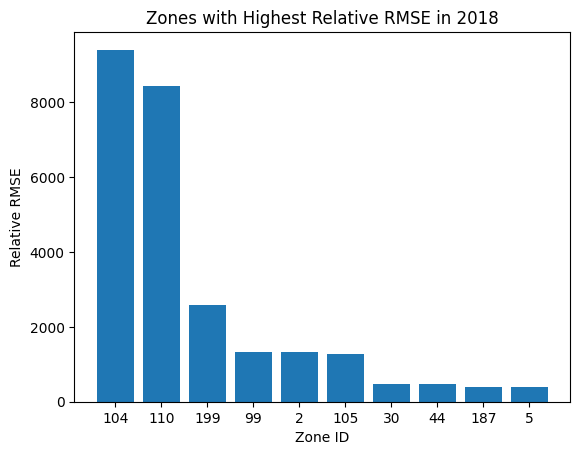

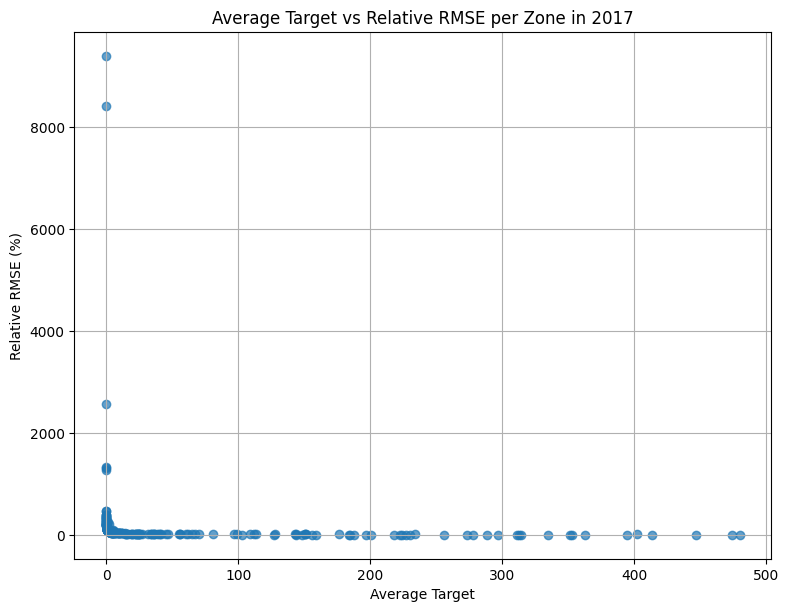

In [146]:
import pandas as pd
import matplotlib.pyplot as plt


zone_df = pd.read_csv('test/per_zone_metrics_with_mean.csv')

plt.figure(figsize=(8, 6))
plt.scatter(zone_df['mean_actual'], zone_df['Relative_MAE_%'], alpha=0.7)
plt.xlabel('Average Target')
plt.ylabel('Relative MAE (%)')
plt.grid(True)
plt.tight_layout()
plt.title('Average Target vs Relative MAE per Zone in 2017')
plt.savefig('Figures/train/targetvsrelativeMAE.png', dpi=300, bbox_inches='tight')
plt.show()

top_mae = zone_df.sort_values('Relative_RMSE_%', ascending=False).head(10)
plt.figure()
plt.bar(top_mae['zone_id'].astype(str), top_mae['Relative_RMSE_%'])
plt.xlabel('Zone ID')
plt.ylabel('Relative RMSE')
plt.title('Zones with Highest Relative RMSE in 2018')
plt.savefig('Figures/train/top10_mae_zones.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(zone_df['mean_actual'], zone_df['Relative_RMSE_%'], alpha=0.7)
plt.xlabel('Average Target')
plt.ylabel('Relative RMSE (%)')
plt.grid(True)
plt.tight_layout()
plt.title('Average Target vs Relative RMSE per Zone in 2017')
plt.savefig('Figures/train/targetvsrelativeRMSE.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

zone_df = pd.read_csv('test/per_zone_metrics_with_mean_test.csv')

plt.figure(figsize=(8, 6))
plt.scatter(zone_df['mean_actual'], zone_df['Relative_MAE_%'], alpha=0.7)
plt.xlabel('Average Target')
plt.ylabel('Relative MAE (%)')
plt.grid(True)
plt.tight_layout()
plt.title('Average Target vs Relative MAE per Zone in 2018')
plt.savefig('Figures/test/targetvsrelativeMAE.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(zone_df['mean_actual'], zone_df['Relative_RMSE_%'], alpha=0.7)
plt.xlabel('Average Target')
plt.ylabel('Relative RMSE (%)')
plt.grid(True)
plt.tight_layout()
plt.title('Average Target vs Relative RMSE per Zone in 2018')
plt.savefig('Figures/train/targetvsrelativeRMSE.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

taxi_zones = gpd.read_file('taxi_zones/taxi_zones.shp')
zone_df = pd.read_csv('test/per_zone_metrics_with_mean.csv')

merged = taxi_zones.merge(zone_df, left_on='LocationID', right_on='zone_id')

metrics = ['mean_actual', 'MAE', 'RMSE', 'R2', 'Relative_MAE_%', 'Relative_RMSE_%']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    merged.plot(
        column=metric,
        ax=axes[i],
        legend=True,
        cmap='OrRd',
        edgecolor='black',
        legend_kwds={'label': metric, 'shrink': 0.5}
    )
    axes[i].set_title(metric, fontsize=12)
    axes[i].axis('off')

   
    #plt.close(fig) 

 ig.savefig(f'Figures/train/final_map.png', dpi=300, bbox_inches='tight')
plt.suptitle('NYC Taxi Zones: Model Metrics per Zone', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

taxi_zones = gpd.read_file('taxi_zones/taxi_zones.shp')
zone_df = pd.read_csv('test/per_zone_metrics_with_mean_test.csv')

merged = taxi_zones.merge(zone_df, left_on='LocationID', right_on='zone_id')

metrics = ['mean_actual', 'MAE', 'RMSE', 'R2', 'Relative_MAE_%', 'Relative_RMSE_%']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    merged.plot(
        column=metric,
        ax=axes[i],
        legend=True,
        cmap='OrRd',
        edgecolor='black',
        legend_kwds={'label': metric, 'shrink': 0.5}
    )
    axes[i].set_title(metric, fontsize=12)
    axes[i].axis('off')
    fig.savefig(f'Figures/test/{metric}_map.png', dpi=300, bbox_inches='tight')

plt.suptitle('NYC Taxi Zones: Model Metrics per Zone', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

taxi_zones = gpd.read_file('taxi_zones/taxi_zones.shp')
zone_df = pd.read_csv('test/per_zone_metrics_with_mean.csv')
merged = taxi_zones.merge(zone_df, left_on='LocationID', right_on='zone_id')

metrics = ['mean_actual', 'MAE', 'RMSE', 'R2', 'Relative_MAE_%', 'Relative_RMSE_%']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    lower = merged[metric].quantile(0.00)
    upper = merged[metric].quantile(0.98)
    clipped_values = merged[metric].clip(lower=lower, upper=upper)

    merged['clipped'] = clipped_values

    merged.plot(
        column='clipped',
        ax=axes[i],
        legend=True,
        cmap='OrRd',
        edgecolor='black',
        legend_kwds={'label': metric, 'shrink': 0.5}
    )
    axes[i].set_title(metric, fontsize=12)
    axes[i].axis('off')
    fig.savefig(f'Figures/train/{metric}_map_Clipped0-0.98.png', dpi=300, bbox_inches='tight')

plt.suptitle('NYC Taxi Zones: Clipped Model Metrics per Zone', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


taxi_zones = gpd.read_file('taxi_zones/taxi_zones.shp')
zone_df = pd.read_csv('test/per_zone_metrics_with_mean_test.csv')
merged = taxi_zones.merge(zone_df, left_on='LocationID', right_on='zone_id')

metrics = ['mean_actual', 'MAE', 'RMSE', 'R2', 'Relative_MAE_%', 'Relative_RMSE_%']


fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):

    lower = merged[metric].quantile(0.00)
    upper = merged[metric].quantile(0.98)
    clipped_values = merged[metric].clip(lower=lower, upper=upper)

    merged['clipped'] = clipped_values

    merged.plot(
        column='clipped',
        ax=axes[i],
        legend=True,
        cmap='OrRd',
        edgecolor='black',
        legend_kwds={'label': metric, 'shrink': 0.5}
    )
    axes[i].set_title(metric, fontsize=12)
    axes[i].axis('off')
    fig.savefig(f'Figures/test/{metric}_map_Clipped0-0.98.png', dpi=300, bbox_inches='tight')

plt.suptitle('NYC Taxi Zones: Clipped Model Metrics per Zone', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os


df = pd.read_csv('newtry/Cleaned_Loss_History.csv')

base_metrics = ['loss', 'mae', 'rmse', 'r2', 'avg_target']
os.makedirs('plots_cleaned_metrics', exist_ok=True)

for metric in base_metrics:
    train_col = f'train_{metric}'
    val_col = f'val_{metric}'

    if train_col in df.columns and val_col in df.columns:
        plt.figure(figsize=(8, 5))
        plt.plot(df['epoch'], df[train_col], label=f'Train {metric.upper()}', color='orange')
        plt.plot(df['epoch'], df[val_col], label=f'Val {metric.upper()}', color='blue')

        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'plots_cleaned_metrics/{metric}_over_epochs.png', dpi=300, bbox_inches='tight')
        plt.show()


In [ ]:
import shutil
shutil.make_archive('Figures', 'zip', 'Figures')
